# Travel Order Resolver

Ce document explore la problèmatique d'extraction d'information de localisation. 

text => entities (dep/des) => json (lag/long)



# Custom Named Entity Recognition Model 

### NER

Les entitiées (entities) sont des mots présent dans un texte donnée et qui correspondent à un type spécifique de donnée. Ce peut être une valeur numérique, une date, un nom, une localisation ou encore une entité géo-politique. Le nombre d'entité à reconnaitre par un modèle est défini par le designer de ce dernie. Donc la seule limite est le scope défini par la problématique à laquelle il est nécessaire de répondre.

La NER est donc le processus par lequel un système va prendre en entré un texte (donnée non structuré) et fournir en output une donnée structuré (un JSON par exemple).

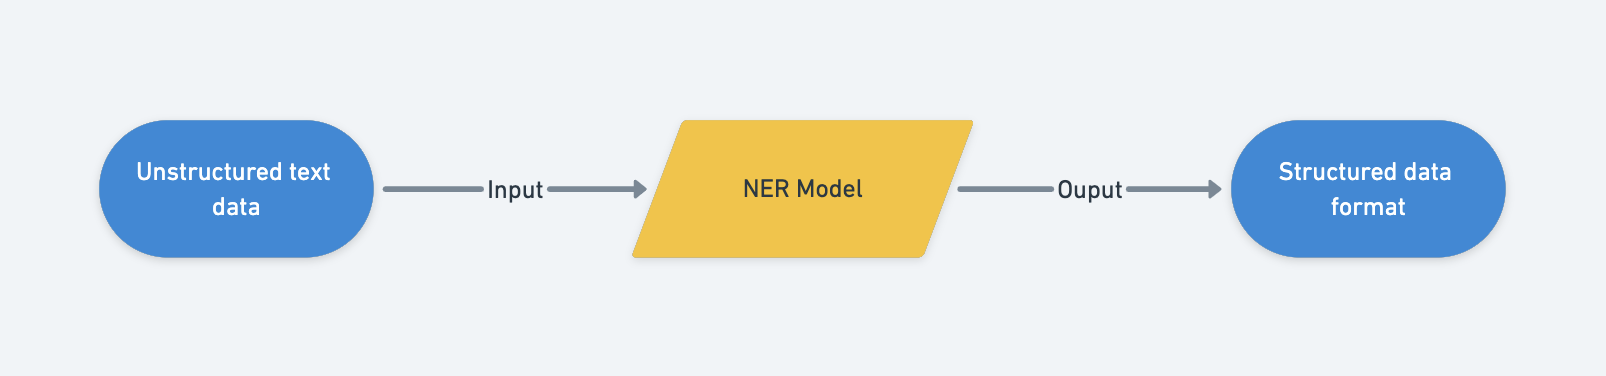

Considérons l'exemple suivant: 

```
Je recherche un train depuis Reims jusqu'à Lyon le 27 novembre 2021 vers 10h
```

Dans cet exemple nous pouvons extraire des entités potentiels tel que:

| Entities         | Type |
|------------------|------|
| Reims            | LOC  |
| Lyon             | LOC  |
| 27 novembre 2021 | DATE |
| 10 heure     | HOUR |

### Multi-word Tokens

Toutes les entités ne sont pas représenté par un unique mot. Certaines entités sont ce qu'on appelle des ***Multi-Word-Tokens***. 

Par exemple dans la phrase: 

```
Je recherche un train depuis Reims jusqu'à gare de Lyon le 27 novembre 2021 vers 10h
```

Ici ```Lyon``` peut être extrait comme une entité de localisation ou alors extraire ```gare de Lyon``` comme une seule entité.  


# Le scope de notre model 

Pour notre cas d'utilisation nous allons utiliser une phrase donnée par un utilisateur souhaitant réaliser un trajet entre deux villes.

L'objectif pour notre model est donc de prédir dans cette phrase, quelle est la ville de départ et quelle est la ville d'arrivée.

```
Je recherche un train depuis Paris jusqu'à Lyon
```

| Entities         | Type |
|------------------|------|
| Paris            | DEP  |
| Lyon             | DES  |



```
DES = "destination"
DEP = "departure"
```



# Entrainement du model

L'objectif lorsque nous allons entrainer notre model n'est pas de simplement lui faire mémoriser que *"Paris"* est une ville, mais plutôt que dans la contexte de la phrase "Je veux un train pour Paris depuis Lyon" la ville de "Paris" est surement la **destination**. 

Notre model doit donc être capable de déterminer statistiquement dans la phrase "Je souhaite un train pour Nice depuis Marseille" que "Nice" est donc la ville de **destination**.

### Les données d'entrainement

Elles jouent un rôle cruciales dans les performances du model. 

En effet imaginons un model entrainé sur des données récupérées sur les mails reçus par un support client sera très mauvais pour qualifié la demande de contact reçu par l'équipe des ventes par exemple. 

Un model doit être entrainé à reconnaitre les entités sur des phrases qui correspondent à un scope spécifique. C'est pour cela que les données d'entrainement **doivent toujours être représentatives des données qu'on voudra traiter**.  

Donc si dans notre cas notre problématique business est de pouvoir reconnaitre dans une phrase d'un utilisateur la ville de départ et d'arrivée alors il faut nous prémunir de données d'entrainement qui représentent ces cas d'utilisation.



```
Je cherche un train depuis Paris pour Marseille

Je suis à la recherche d’un billet depuis Paris pour Lyon 

Est ce qu’il y’a un train pour Paris depuis Strasbourg ?

Y’a-t-il un trajet depuis Reims pour Châlons-en-Champagne ?
```





### Les données d'évaluation

Parce que nous avons besoin que notre model soit général pour le scope business voulu, nous avons besoin de donnée d'évaluation pour le tester.

```
Trouve moi un train qui part de Nice à Fréjus 

Quel est le meilleur moyen de rejoindre Saint-Quentin depuis Meaux ?

Je veux obtenir le trajet de Paris à Hyères 

Obtient moi un train depuis Chambéry jusqu’à Gare de Lyon 
```



## La taille des données d'entrainement et de test

Pour entrainer et tester un model correctement, i est recommander de commencer avec quelques centaines de phrases par dataset. Il est recommandé dans la plupart des cas de débuter avec au moins 200 exemples.

# Récupération des données d'entrainement

On va importer le fichier .csv qui va contenir les phrases d'entrainement de notre model qui ont été récoltés auprès de nos utilisateurs. C'est notre base à partir de laquelle on va pouvoir entrainer notre bot.

In [1]:
# Import training phrases csv file
import csv

csv_path = "/content/corpus.csv"

corpus = []

with open(csv_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        corpus.append({'text': row[0], 'dep': row[1], 
                        'des': row[2]})

# Delete csv header
corpus.pop(0)
        
print(corpus)

[{'text': 'Je cherche un train depuis Paris pour Marseille', 'dep': 'Paris', 'des': 'Marseille'}, {'text': 'Je suis à la recherche d’un billet depuis Paris pour Lyon', 'dep': 'Paris', 'des': 'Lyon'}, {'text': 'Est ce qu’il y’a un train pour Paris depuis Strasbourg ?', 'dep': 'Strasbourg', 'des': 'Paris'}, {'text': 'Y’a-t-il un trajet depuis Reims pour Châlons-en-Champagne ?', 'dep': 'Reims', 'des': 'Châlons-en-Champagne'}, {'text': 'Un train pour Lyon à partir de Saint-Etienne', 'dep': 'Saint-Etienne', 'des': 'Lyon'}, {'text': 'Un trajet de Paris à Reims', 'dep': 'Paris', 'des': 'Reims'}, {'text': 'Un train de Rennes à Bordeaux', 'dep': 'Rennes', 'des': 'Bordeaux'}, {'text': 'Un train pour Reims depuis Strasbourg', 'dep': 'Strasbourg', 'des': 'Reims'}, {'text': 'Un trajet pour Lyon depuis Nîmes', 'dep': 'Nîmes', 'des': 'Lyon'}, {'text': 'Est ce qu’il y’a des trains de Gare de l’Est à Strasbourg ?', 'dep': 'Gare de l’Est', 'des': 'Strasbourg'}, {'text': 'Je veux partir à Lille depuis Ga

In [2]:
# Get sample of the corpus 
print(corpus[0])

{'text': 'Je cherche un train depuis Paris pour Marseille', 'dep': 'Paris', 'des': 'Marseille'}


# Training Sets
Les données pour entrainées un model de machine learning existent sous trois formes:

*   Les données d'entrainement
*   Les données de validation
*   Les données de test

Toutes ces données vont être strucutrées de la même manière, c'est à dire sous la forme d'une liste de données structurées dans laquelle chaque index va contenir une chaine de caractère qui va représenter un texte (la requête de l'utilisateur).

Le second composant de nos données d'entrainement va va être composé d'une liste d'entités à extraire présentes dans ce texte avec pour chacune d'elle la position de départ dans la string, la position de fin, ainsi que le label auquel cette entité doit être assosiées.

Durant la phase d'entrainement de notre model, ces annotations vont permettre au réseau de neurone (architecture de ML utilisé par spaCy) d'apprendre de ces données pour être capable d'identifier correctement les entitées sur lequelles on souhaite l'entrainer.

Voici la forme que doit prendre notre set d'entrainement:

`TRAIN_DATA = [ (TEXT AS A STRING, {“entities”: [(START, END, LABEL)]}) ]`

In [3]:
import re

TRAIN_DATA = []

# Get start and end position of the token inside the text value
def get_position(text, token):
  for match in re.finditer(token, text):
    return (match.start(), match.end()) 

# Get entity format (START, END, LABEL)
def get_entity(text, token, label):
  start, end = get_position(text, token)
  return (start, end, label)

for sentence in corpus:
  text = sentence["text"]
  get_entity(text, sentence["des"], "DES")
  print(text, sentence["dep"], "DEP")
  get_entity(text, sentence["dep"], "DEP")
  # item => (TEXT AS A STRING, {“entities”: [(START, END, LABEL)]}) 
  item = (text, {"entities": [get_entity(text, sentence["dep"], "DEP"), get_entity(text, sentence["des"], "DES")]})
  TRAIN_DATA.append(item)

print(TRAIN_DATA)

Je cherche un train depuis Paris pour Marseille Paris DEP
Je suis à la recherche d’un billet depuis Paris pour Lyon Paris DEP
Est ce qu’il y’a un train pour Paris depuis Strasbourg ? Strasbourg DEP
Y’a-t-il un trajet depuis Reims pour Châlons-en-Champagne ? Reims DEP
Un train pour Lyon à partir de Saint-Etienne Saint-Etienne DEP
Un trajet de Paris à Reims Paris DEP
Un train de Rennes à Bordeaux Rennes DEP
Un train pour Reims depuis Strasbourg Strasbourg DEP
Un trajet pour Lyon depuis Nîmes Nîmes DEP
Est ce qu’il y’a des trains de Gare de l’Est à Strasbourg ? Gare de l’Est DEP
Je veux partir à Lille depuis Gare du Nord Gare du Nord DEP
Peux tu me trouver un trajet Reims/Paris ? Reims DEP
Y’a-t-il un train qui va de Bordeaux à Biarritz ? Bordeaux DEP
Je recherche un train de Nice à Lyon Nice DEP
Comment je peux aller de Paris à Lyon Paris DEP
Donne moi un train depuis Orléans jusqu’à Rouen Orléans DEP
Comment je me rend à Paris depuis Nancy ? Nancy DEP
J’ai besoin de me rendre à Marseill

In [4]:
# Get sample of training set
print(TRAIN_DATA[0])

('Je cherche un train depuis Paris pour Marseille', {'entities': [(27, 32, 'DEP'), (38, 47, 'DES')]})


# Conception du model NER

In [5]:
from pathlib import Path

model = None
output_dir=Path("/content")
n_iter=100

In [6]:
import spacy

#load the model
if model is not None:
    nlp = spacy.load(model)  
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('fr')  
    print("Created blank 'fr' model")

#set up the pipeline

# create the built-in pipeline components and add them to the pipeline

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
  ner = nlp.create_pipe("ner")
  nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
  ner = nlp.get_pipe("ner")
  
# add labels
for _, annotations in TRAIN_DATA:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

# if 'ner' not in nlp.pipe_names:
#     ner = nlp.create_pipe('ner')
#     nlp.add_pipe(ner, last=True)
# else:
#     ner = nlp.get_pipe('ner')

Created blank 'fr' model


# Entrainement du model

In [7]:
from spacy.util import minibatch, compounding
import random

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):  # only train NER
  # reset and initialize the weights randomly – but only if we're
  # training a new model
  if model is None:
    nlp.begin_training()
    for itn in range(n_iter):
      random.shuffle(TRAIN_DATA)
      losses = {}
      # batch up the examples using spaCy's minibatch
      batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
      for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
          texts,  # batch of texts
          annotations,  # batch of annotations
          drop=0.5,  # dropout - make it harder to memorise data
          losses=losses)
        print("Losses", losses)

Losses {'ner': 31.59999966621399}
Losses {'ner': 72.61332631111145}
Losses {'ner': 103.86462807655334}
Losses {'ner': 124.05144786834717}
Losses {'ner': 153.24810361862183}
Losses {'ner': 189.36361145973206}
Losses {'ner': 208.97191655635834}
Losses {'ner': 220.67029309272766}
Losses {'ner': 22.53092908859253}
Losses {'ner': 43.018840074539185}
Losses {'ner': 54.21017920970917}
Losses {'ner': 68.9506585597992}
Losses {'ner': 86.69089263677597}
Losses {'ner': 100.71383909881115}
Losses {'ner': 115.70431707799435}
Losses {'ner': 125.26012496650219}
Losses {'ner': 13.948223136365414}
Losses {'ner': 28.674435935914516}
Losses {'ner': 40.54172897711396}
Losses {'ner': 55.21291369572282}
Losses {'ner': 69.51242871209979}
Losses {'ner': 82.29355848580599}
Losses {'ner': 96.01474353671074}
Losses {'ner': 107.89664283208549}
Losses {'ner': 13.092217609286308}
Losses {'ner': 27.00294966995716}
Losses {'ner': 40.55550046265125}
Losses {'ner': 51.84688949584961}
Losses {'ner': 61.582392036914825}


# Tester le model

In [ ]:
 # test the trained model

 # IOB code of named entity tag. 3 means the token begins an entity, 2 means it
 # is outside an entity, 1 means it is inside an entity, and 0 means no entity 
 # tag is set.
 
for text, _ in TRAIN_DATA:
  doc = nlp(text)
  print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
  print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

In [70]:
# This part will create a JSON from the sentence with destination and departure keys

import json

def create_dic(text):
  doc = nlp(text)
  dictionary = {}

  for ent in doc.ents:
    if ent.label_ == 'DEP':
      dictionary['dep'] = ent.text
    if ent.label_ == 'DES':
      dictionary['des'] = ent.text

  print(dictionary)
  return dictionary

def create_json(text):
  doc = nlp(text)
  dictionary = {}

  for ent in doc.ents:
    if ent.label_ == 'DEP':
      dictionary['dep'] = ent.text
    if ent.label_ == 'DES':
      dictionary['des'] = ent.text

  jsonString = json.dumps(dictionary, indent=4)
  print(jsonString)
  return jsonString

create_json('Je cherche un train depuis Bresl pour Dijon')

{
    "dep": "Bresl",
    "des": "Dijon"
}


'{\n    "dep": "Bresl",\n    "des": "Dijon"\n}'

## Comment corriger les noms de ville mal orthographiés ? 

In [60]:
import difflib

def is_similar(first, second, ratio):
    return difflib.SequenceMatcher(None, first, second).ratio() > ratio

def compare_location_to_database(location, knowledge_base, ratio):

  result = []
  
  s = location.title()

  for c in knowledge_base: 
    if is_similar(s,c, ratio):
      result.append(c)

  return result

# Ratio to compare
ratio = 0.7

# Misspelled city name
city_name = 'Mans'

# knowledge base to search the correctly spelled city name
base = ['New York', 'Amsterdam', 'Barcelona', 'Berlin', 'Prague', 'Le Mans']

compare_location_to_database(city_name, base, ratio)

['Le Mans']

In [20]:
import csv
import pandas as pd

csv_path = "/content/fr.csv"

df = pd.read_csv(csv_path)  

df.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Paris,48.8566,2.3522,France,FR,Île-de-France,primary,11020000.0,2148271.0
1,Nice,43.7034,7.2663,France,FR,Provence-Alpes-Côte d’Azur,minor,1006402.0,341032.0
2,Toulouse,43.6045,1.4440,France,FR,Occitanie,admin,968638.0,486828.0
3,Marseille,43.2964,5.3700,France,FR,Provence-Alpes-Côte d’Azur,admin,870018.0,868277.0
4,Rennes,48.1147,-1.6794,France,FR,Bretagne,admin,727357.0,217728.0


In [21]:
print(df.shape[0])

9683


In [23]:
cities_name = df["city"]

cities_name.head()



0        Paris
1         Nice
2     Toulouse
3    Marseille
4       Rennes
Name: city, dtype: object

In [50]:
# Try algo in a sample of cities

location = 'Renne'

correct = '' 

for x in range(0, 5):
  c = cities_name[x]
  if is_similar(location,c, 0.70):
      correct = c

print(correct)

Rennes


In [99]:
locations = create_dic('Je veux un train pour Mans depuis Dujon')

departure = locations["dep"]

# Method to find the most accurate city name
def find_correct_location(entity):
  prob = compare_location_to_database(entity, cities_name, 0.7)

  if len(prob) == 0:
    return None
  else:
    ratios = []

    for c in prob: 
      ratio = difflib.SequenceMatcher(None, location, c).ratio()
      ratios.append(ratio)


    max_value = max(ratios)
    max_index = ratios.index(max_value)

    return prob[max_index]

print(find_correct_location(departure))
print(find_correct_location('gdsggsd'))

{'des': 'Mans', 'dep': 'Dujon'}
Dijon
None
